**1. Data Preparation and Exploration**

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("exchange_rate.csv")
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [3]:
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [5]:
df.dtypes

date        object
Ex_rate    float64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [7]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7583    False
7584    False
7585    False
7586    False
7587    False
Length: 7588, dtype: bool

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

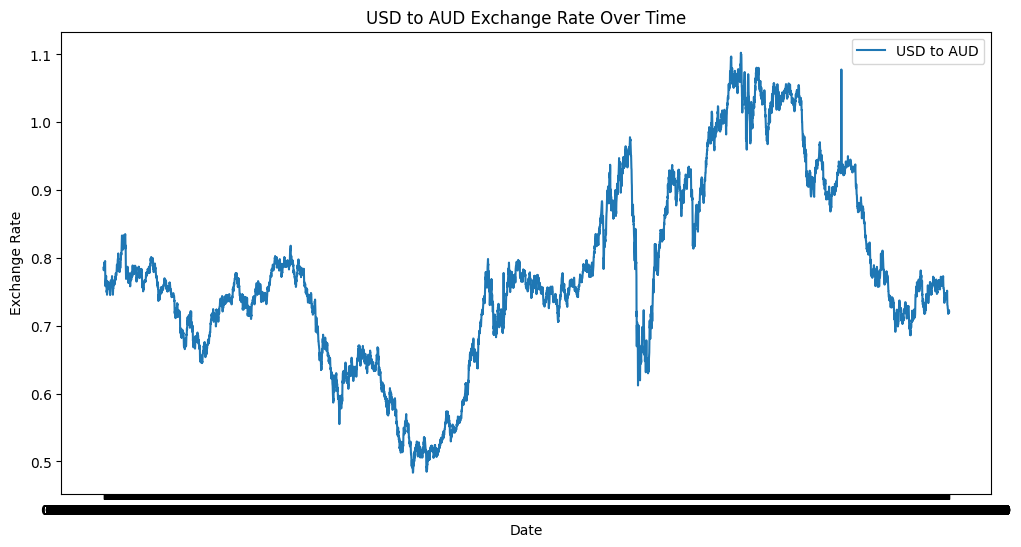

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['Ex_rate'], label='USD to AUD')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

**2. Model Building - ARIMA**

In [ ]:
!pip install statsmodels

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1200x600 with 0 Axes>

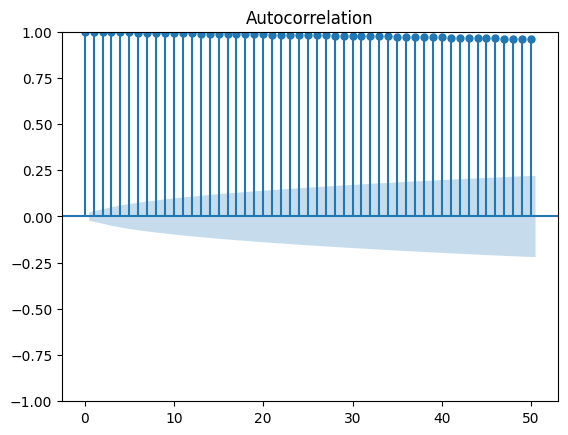

In [14]:
plt.figure(figsize=(12, 6))
plot_acf(df['Ex_rate'], lags=50)
plt.show()

<Figure size 1200x600 with 0 Axes>

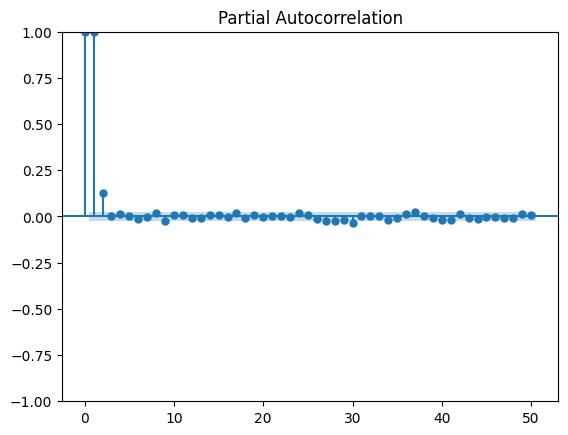

In [15]:
plt.figure(figsize=(12, 6))
plot_pacf(df['Ex_rate'], lags=50)
plt.show()

In [16]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
model_fit = model.fit()

In [18]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 12 Mar 2025   AIC                         -56102.322
Time:                        18:53:41   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

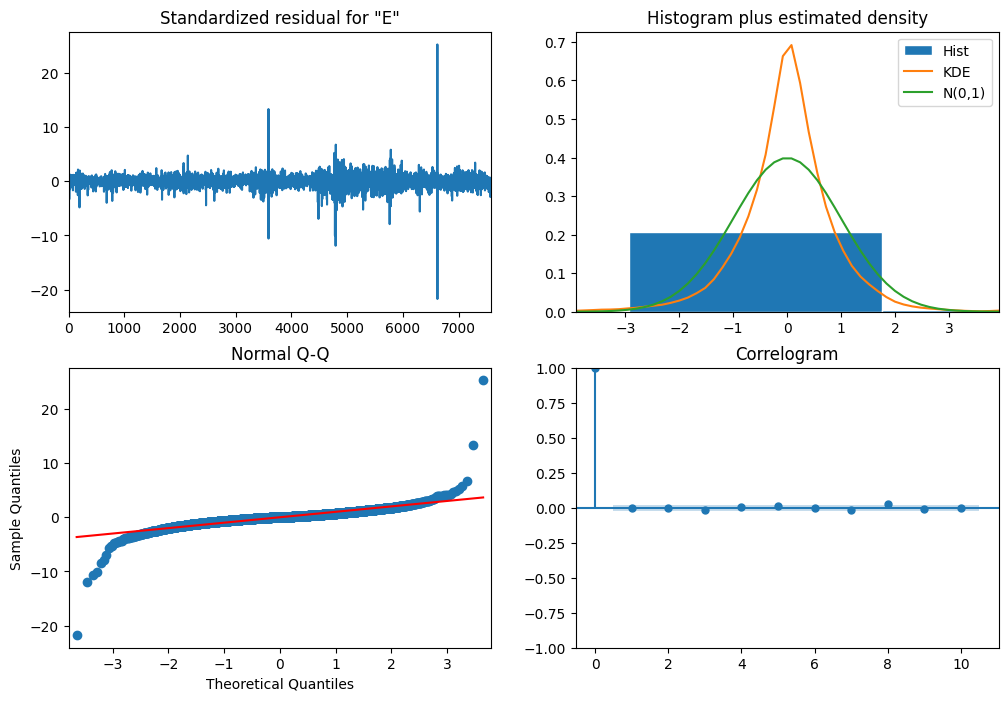

In [19]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [20]:
forecast = model_fit.get_forecast(steps=10)
forecast_df = forecast.conf_int()
forecast_df['forecast'] = forecast.predicted_mean

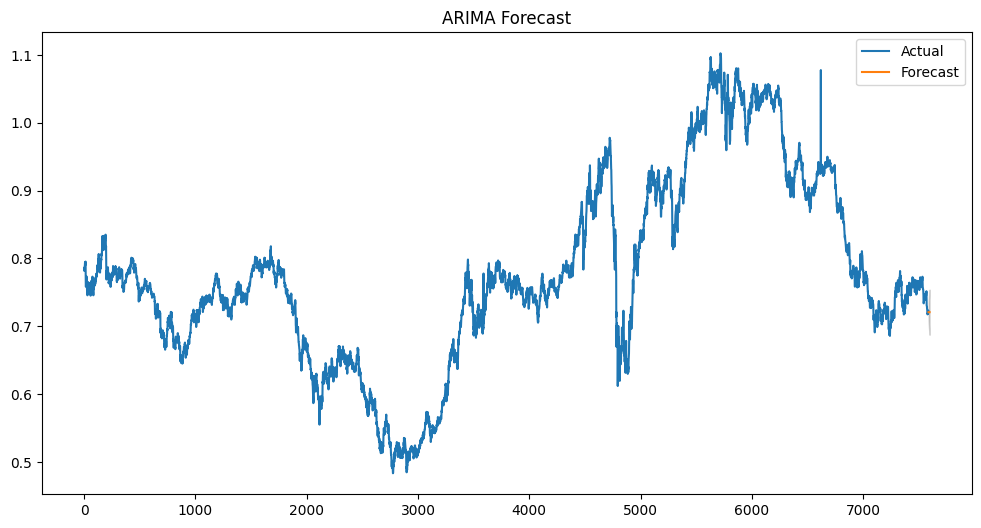

In [21]:
# Plot actual and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(range(len(df), len(df) + 10), forecast_df['forecast'], label='Forecast')
plt.fill_between(range(len(df), len(df) + 10),
                 forecast_df.iloc[:, 0], forecast_df.iloc[:, 1], color='gray', alpha=0.3)
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

**3. Model Building - Exponential Smoothing**

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [23]:
# Holt-Winters model
hw_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None).fit()

In [24]:
hw_forecast = hw_model.forecast(10)

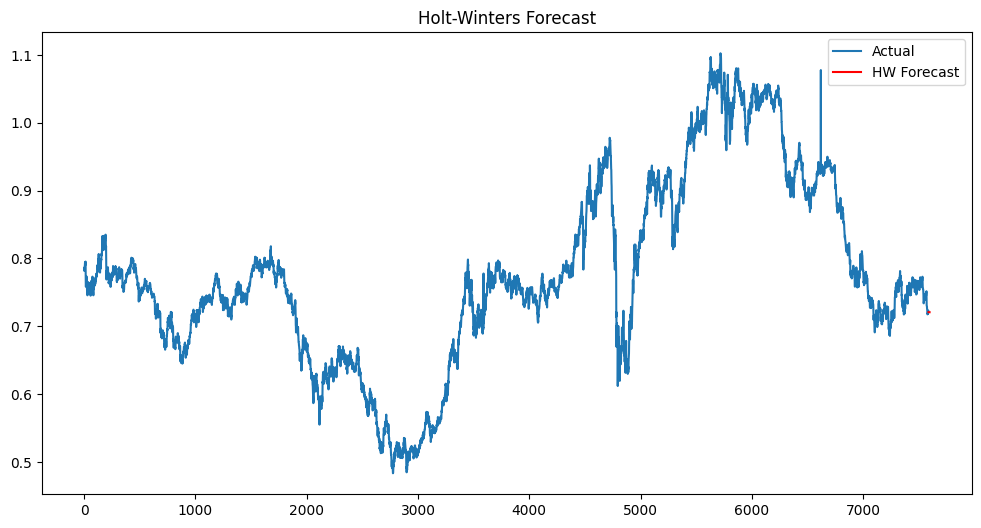

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(range(len(df), len(df) + 10), hw_forecast, label='HW Forecast', color='red')
plt.title('Holt-Winters Forecast')
plt.legend()
plt.show()

**4. Evaluation and Comparison**

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [27]:
# Calculate errors for ARIMA
arima_mae = mean_absolute_error(df['Ex_rate'][-10:], forecast_df['forecast'])
arima_rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-10:], forecast_df['forecast']))

In [28]:
# Calculate errors for Holt-Winters
hw_mae = mean_absolute_error(df['Ex_rate'][-10:], hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-10:], hw_forecast))

In [29]:
# Print error metrics
print(f"ARIMA - MAE: {arima_mae}, RMSE: {arima_rmse}")
print(f"Holt-Winters - MAE: {hw_mae}, RMSE: {hw_rmse}")

ARIMA - MAE: 0.001556771200434226, RMSE: 0.0018425706107113402
Holt-Winters - MAE: 0.001574070641361358, RMSE: 0.0018519598744416396


In [30]:
# Compare performance based on error metrics
print("ARIMA performed better" if arima_rmse < hw_rmse else "Holt-Winters performed better")


ARIMA performed better
